In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from src.data.dataloader import build_dataloaders
from src.data.transforms import get_transforms
from src.trainer.trainer import Trainer
from src.utils.set_seed import set_seed

set_seed()
config = OmegaConf.load("../configs/config.yaml")

In [2]:
print("Num of epochs:", config.training.num_epochs)
print("Fine tune:", config.training.fine_tune.strategy)
print("Model", config.model.name)
print("Optimizer:", config.optimizer.name)
print("Use class weights:", config.model.use_class_weights)
print("Use sampler:", config.data.sampler.enable)
print("Validation split:", config.data.val_split)

Num of epochs: 10
Fine tune: full
Model resnet18
Optimizer: adam
Use class weights: False
Use sampler: True
Validation split: 0.3


In [3]:
_, val_transform, class_transforms_dict = get_transforms(config)
_, val_loader = build_dataloaders(config, val_transform=val_transform, class_transforms_dict=class_transforms_dict)

26.12.2025  12:29:00 - INFO - Using WeightedRandomSampler for train data loader.


In [4]:
trainer = Trainer(config)
trainer.load_model()

avg_loss, metrics = trainer.evaluate(val_loader)
targets = metrics['targets'].numpy()
predictions = metrics['preds'].numpy()

26.12.2025  12:29:00 - INFO - Using device: mps
26.12.2025  12:29:00 - INFO - Loaded model weights from: /Users/eldarkerimov/Projects/cabinet_classification/artifacts/models/model.pth


Loading training history from: /Users/eldarkerimov/Projects/cabinet_classification/artifacts/models/history_model.pth


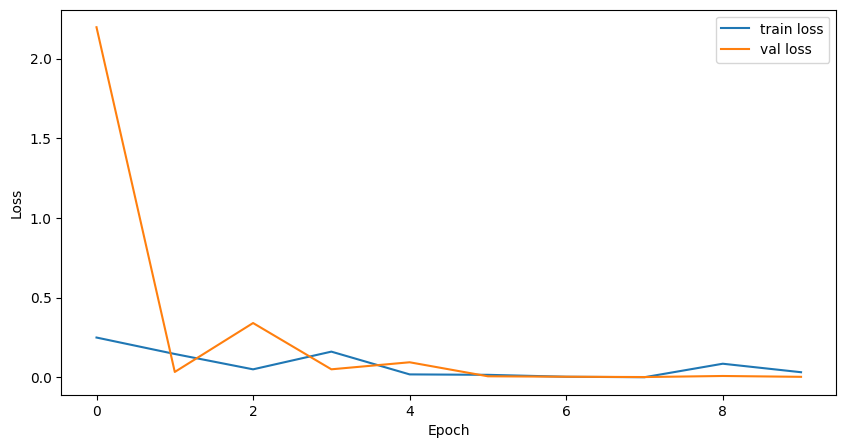

In [5]:
root_dir = Path().resolve().parent
path_to_history = root_dir / Path(config.model.save_path) / f"history_{config.model.experiment_name}"
print(f"Loading training history from: {path_to_history}")
loaded_history = torch.load(path_to_history)

plt.figure(figsize=(10, 5))
plt.plot(loaded_history['train_loss'], label='train loss')
plt.plot(loaded_history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

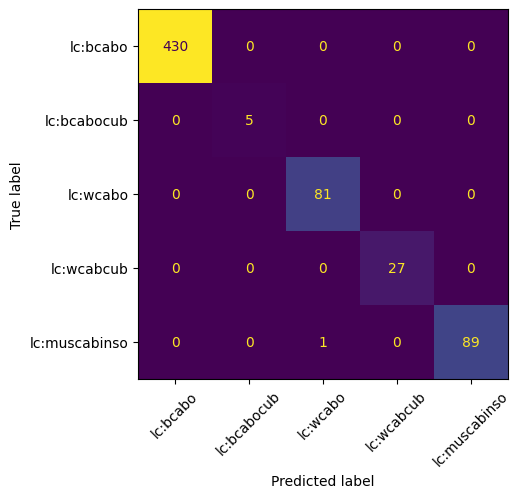

In [6]:
cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.data.target_categories)
disp.plot(colorbar=False)
plt.xticks(rotation=45);

In [7]:
report = classification_report(targets, predictions, target_names=config.data.target_categories)
print(report)

               precision    recall  f1-score   support

     lc:bcabo       1.00      1.00      1.00       430
  lc:bcabocub       1.00      1.00      1.00         5
     lc:wcabo       0.99      1.00      0.99        81
   lc:wcabcub       1.00      1.00      1.00        27
lc:muscabinso       1.00      0.99      0.99        90

     accuracy                           1.00       633
    macro avg       1.00      1.00      1.00       633
 weighted avg       1.00      1.00      1.00       633



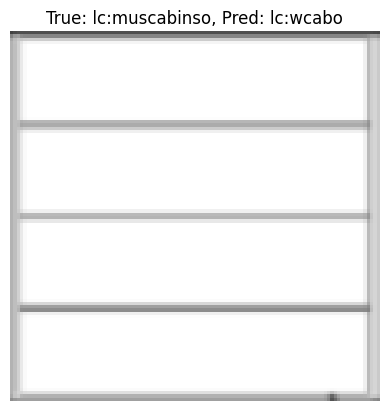

In [8]:
wrong = np.where(targets != predictions)[0]
for idx in wrong:
    img, true_label = val_loader.dataset[idx]
    pred_label = predictions[idx]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {config.data.target_categories[int(true_label)]}, Pred: {config.data.target_categories[int(pred_label)]}")
    plt.axis('off')
    plt.show()